In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os, sys, json
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
sys.path.append('..')
from oads_access.oads_access import *

import torch.optim as optim
import torch
from torch import nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

os.environ['MKL_THREADING_LAYER'] = 'GNU'
torch.multiprocessing.set_start_method('spawn')

# Initialize Data Access

In [2]:
%matplotlib widget
home = '../../data/oads/mini_oads/'
oads = OADS_Access(home)

In [3]:
# Load Data
data = oads.get_data_iterator()

In [4]:
# Load iterator through crops corresponding to annotation boxes
crops = oads.get_crop_iterator(data)

# Visualize Data

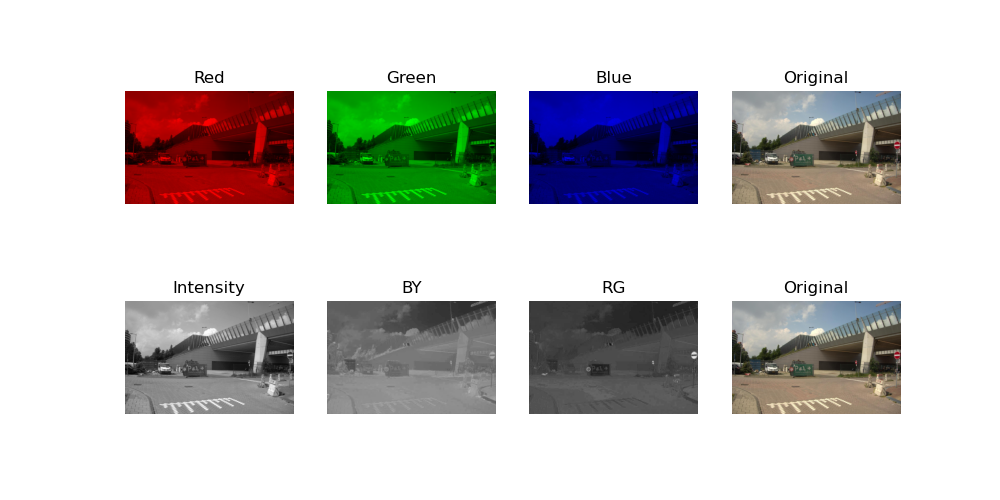

In [5]:
# Plot original image together with RGB color channels and opponent channels
image = np.array(data[0][0])

fig = plot_image_in_color_spaces(image, cmap_opponent='gray')

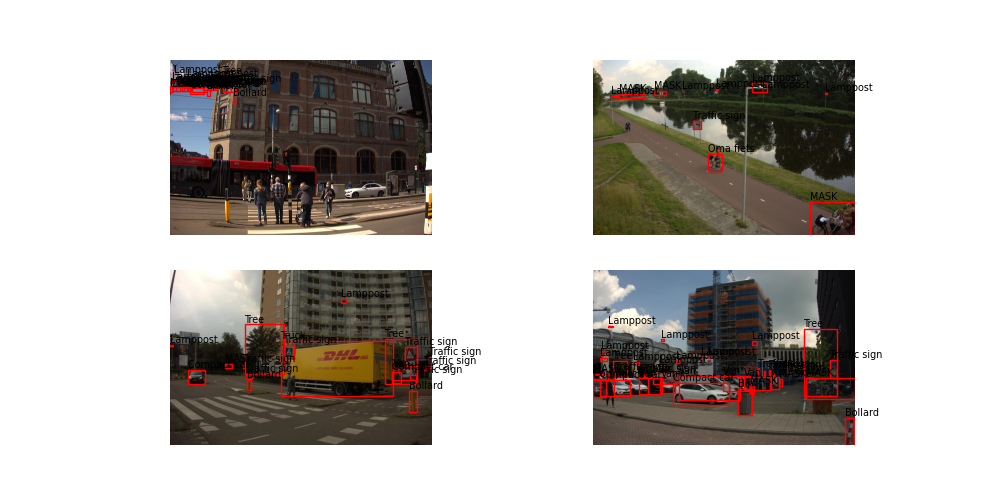

In [6]:
# Plot Images with annotation boxes
fig, ax = plt.subplots(2,2, figsize=(10, 5))
for (img, label), axis in zip(data[25:], ax.flatten()):
    # print(label)
    axis.imshow(img)
    add_label_box_to_axis(label, axis, add_title=True)
    axis.axis('off')

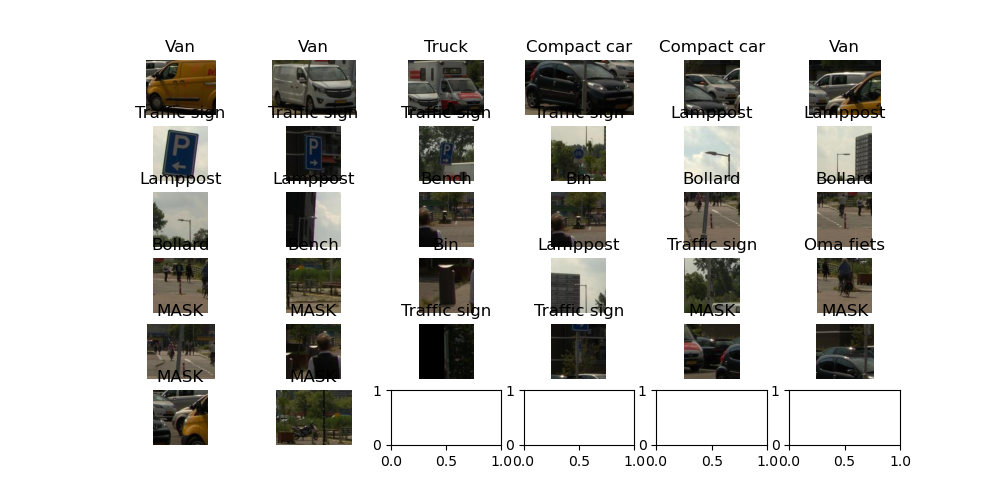

In [7]:
# Plot each crop corresponding to a annotation box in a subplot
fig = plot_crops_from_data_tuple(data[7], min_size=(100, 100), figsize=(10, 5), max_size=None)

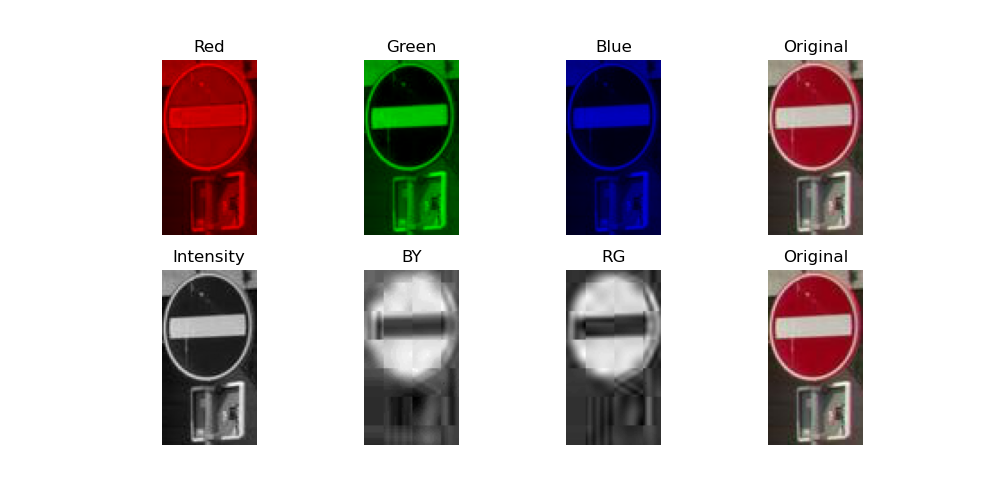

In [8]:
# Plot crop together with RGB color channels and opponent channels
image = np.array(crops[0][0])

fig = plot_image_in_color_spaces(image, cmap_opponent='gray')

# Prepare dataset for DNN training

In [9]:
train_crops, val_crops, test_crops = oads.get_train_val_test_split(crops, file_formats=['.jpg'])

In [10]:
class TestModel(nn.Module):
    def __init__(self, input_channels, output_channels, input_shape) -> None:
        super(TestModel, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=(3,3), padding='valid'),       # ((100,100) - (3,3)) / 1 + 1   = (98,98)
            nn.Conv2d(32, 2, kernel_size=(3,3), padding='valid'),                    # ((98,98) - (3,3)) / 1 + 1     = (96,96)
            nn.Flatten(),
        )
        self.fc = nn.Linear(in_features=96*96*2, out_features=output_channels)

    def forward(self, x):
        # print(f"Input shape: {x.shape}")
        z = self.layers(x)
        # print(f"After conv shape: {z.shape}")
        return self.fc(z)

In [11]:
train_data, val_data, test_data = oads.get_train_val_test_split(use_crops=True, min_size=(100,100), max_size=(100,100))
input_channels = np.array(train_data[0][0]).shape[-1]

output_channels = len(oads.get_class_mapping())

In [12]:
class_index_mapping = {key: index for index, key in enumerate(list(oads.get_class_mapping().keys()))}

In [13]:
model = TestModel(input_channels=input_channels, output_channels=output_channels, input_shape=(100,100))
model = model.to('cuda:0')

In [14]:
batch_size = 10

transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

traindataset = OADSImageDataset(data=train_data, class_index_mapping=class_index_mapping, transform=transform)
valdataset = OADSImageDataset(data=val_data, class_index_mapping=class_index_mapping, transform=transform)
testdataset = OADSImageDataset(data=test_data, class_index_mapping=class_index_mapping, transform=transform)

trainloader = DataLoader(traindataset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(valdataset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testdataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [15]:
# from torchvision.utils import make_grid

# dataiter = iter(trainloader)
# images, labels = dataiter.next()

# # def imshow(img):
# # #     npimg = img.numpy()
# #     plt.imshow(np.transpose(img, (1,2,0)))
# #     plt.show()

# # imshow(make_grid(images))
# # images

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [17]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # inputs = inputs.float()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print(f'Finished Training with loss: {loss.item()}')

RuntimeError: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

# Non-functional: Downsample the resolution like a gaussian filter
Such that the resolution in the middle of the annotation box is basically kept and the resolution decrease towards the edges of the image

In [235]:
_x = np.array(data[0][0])

1. Create Gaussian with same size as data
2. Normalize between 0 and 1
3. Interpret each entry as probability on whether the pixel is kept

In [286]:
height = data[0][1]['size']['height']
width = data[0][1]['size']['width']

In [305]:
x_grid = np.linspace(0, width, width, endpoint=True)
y_grid = np.linspace(0, height, height, endpoint=True)
x, y = np.meshgrid(x_grid, y_grid)

sigma = 60
mu = (60.0, 60.0)

gaussian = np.exp(-((x-mu[0])**2 + (y-mu[0])**2) / (2*sigma**2)) / (2 * np.pi * sigma**2)

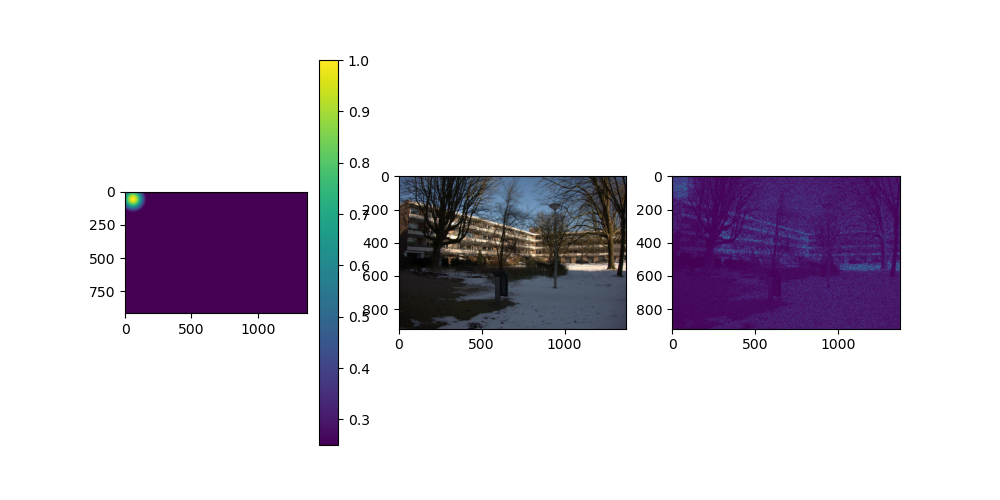

In [306]:
fig, ax = plt.subplots(1,3, figsize=(10,5))
norm = gaussian / np.max(gaussian)
norm = np.where(norm<0.25, 0.25, norm)
bar = ax[0].imshow(norm)
plt.colorbar(bar, ax=ax[0])

ax[1].imshow(data[0][0])

samples = np.random.random((height, width))
# samples = np.where(samples<norm, True, False)
ax[2].imshow(np.where(samples<norm, np.array(data[0][0])[:,:,0], 0))

(array([ 8., 12.,  6., 13., 11., 10., 10., 10.,  8., 12.]),
 array([0.00336121, 0.10182743, 0.20029365, 0.29875988, 0.3972261 ,
        0.49569232, 0.59415854, 0.69262477, 0.79109099, 0.88955721,
        0.98802344]),
 <BarContainer object of 10 artists>)

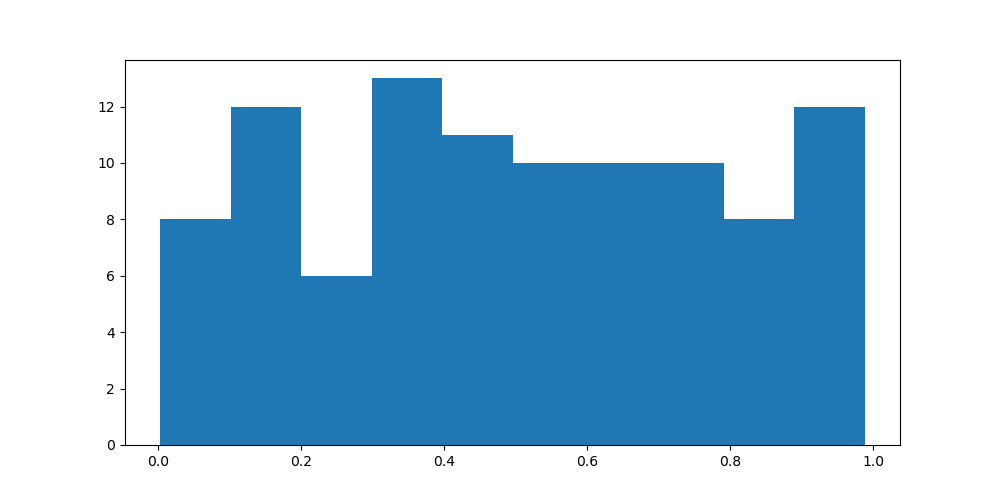

In [244]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.hist(np.random.random(size=(100)).flatten())

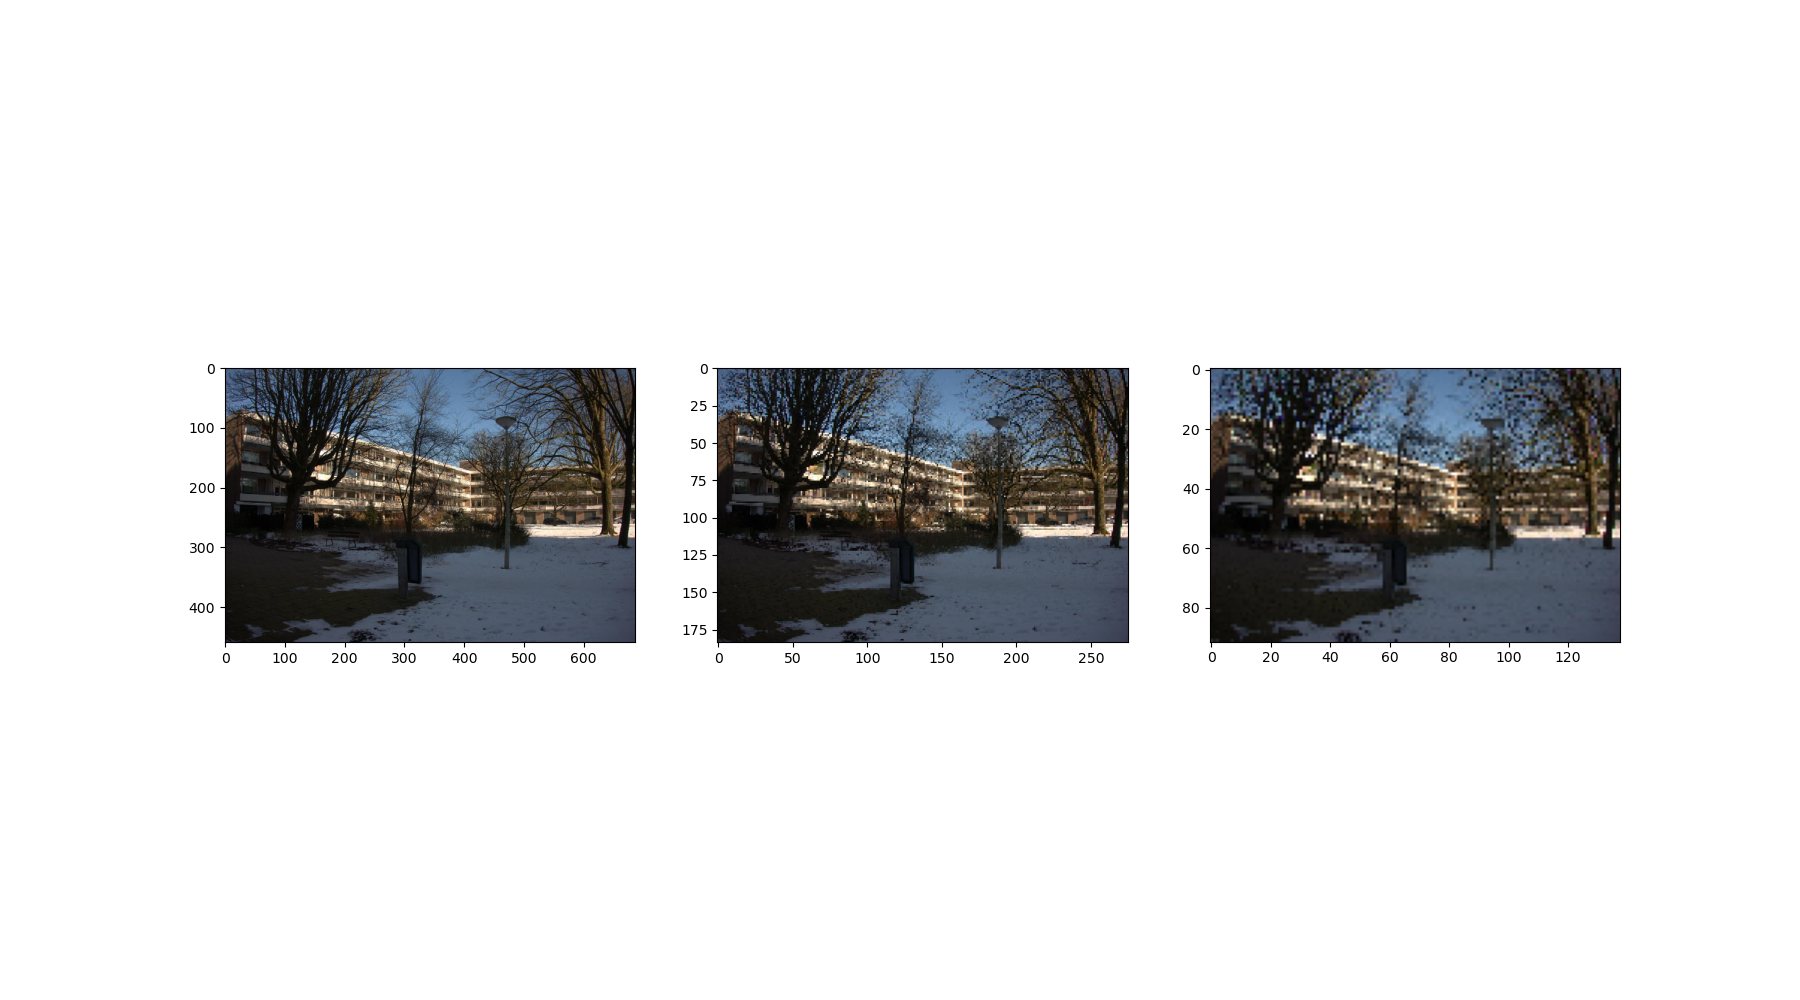

In [226]:
fig, ax = plt.subplots(1,3, figsize=(18,10))

ax[0].imshow(Image.fromarray(_x[::2,::2,:]))
ax[1].imshow(Image.fromarray(_x[::5,::5,:]))
ax[2].imshow(Image.fromarray(_x[::10,::10,:]))